# Comparing Observed vs. Model Return Levels

1. Fit GEV distribution to actual observations with bootstrap confidence intervals
2. Compare with model-predicted curves 

This provides a more rigorous validation approach that tests if our model correctly reproduces observed climate extremes.

In [1]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [ ]:
# Import required libraries
from prob_unet_utils import compute_annual_block_maxima, gev_return_level, gev_parametric_bootstrap, get_empirical_return_periods
import torch
import random
import numpy as np
import climex_utils as cu
from scipy.stats import genextreme
import matplotlib.pyplot as plt
import train_prob_unet_model as tm

In [3]:
args = tm.get_args()

## 1. Load Observed Data

First, we load the real observational data using climex_utils.

In [4]:
# Load observed data
# Setting same years and location as in the model test
args.years_test = range(1998, 2028)
obs_dataset = cu.climex2torch(
    datadir=args.datadir,
    years=args.years_test,
    variables=args.variables,
    coords=args.coords,
    lowres_scale=args.lowres_scale,
    type="lrinterp_to_residuals",
    transfo=True
)

print("Observation dataset length (days):", len(obs_dataset))

Opening and lazy loading netCDF files
Loading dataset into memory
Converting xarray Dataset to Pytorch tensor

##########################################
############ PROCESSING DONE #############
##########################################

Observation dataset length (days): 10950


## 2. Process Observed Data

Now we extract annual maxima from the observed data, specifically for the same pixel location as used in the model testing.

In [5]:
def extract_observed_annual_maxima(dataset, variable='pr', pixel=(70, 63), years=range(1998, 2028)):
    """
    Extract annual maximum values from observed data for a specific pixel and variable.
    
    Args:
        dataset: The dataset containing observational data
        variable: Climate variable ('pr', 'tasmax', or 'tasmin')
        pixel: Tuple of (y, x) coordinates for the pixel of interest
        years: Range of years to process
        
    Returns:
        block_maxima: Array of annual maximum values
    """
    pix_y, pix_x = pixel
    print(f"Extracting observed annual maxima at pixel ({pix_y}, {pix_x}) for {variable}")
    
    total_days = len(dataset)
    days_per_year = 365
    n_years = len(years)
    
    # Check if dataset length matches expected days
    if total_days != n_years * days_per_year:
        print(f"Warning: Dataset length ({total_days}) doesn't match expected days ({n_years * days_per_year})")
    
    # Array to store daily values [total_days]
    daily_data = np.zeros((total_days), dtype=np.float32)
    
    # Extract the value for each day
    for day_idx in range(total_days):
        sample_dict = dataset[day_idx]
        hr = sample_dict['hr']  # High-resolution ground truth
        
        if variable == 'pr':
            # For precipitation: get value and convert to mm/day
            val = cu.kgm2sTommday(cu.softplus(hr[0]))
            pixel_val = val[pix_y, pix_x].item()
        elif variable == 'tasmax':
            # For tasmax: compute and convert from Kelvin to Celsius
            tasmax = hr[1] + cu.softplus(hr[2], c=0)
            tasmax = cu.KToC(tasmax)
            pixel_val = tasmax[pix_y, pix_x].item()
        elif variable == 'tasmin':
            tasmin = hr[1]
            tasmin = cu.KToC(tasmin)
            pixel_val = tasmin[pix_y, pix_x].item()
        else:
            raise ValueError("Unsupported variable. Use 'pr', 'tasmax' or 'tasmin'.")
            
        daily_data[day_idx] = pixel_val
    
    # Reshape to [n_years, days_per_year] for computing annual maxima
    daily_data_reshaped = daily_data.reshape(n_years, days_per_year)
    
    # Compute annual maxima for each year
    block_maxima = np.max(daily_data_reshaped, axis=1)
    
    print(f"Extracted {len(block_maxima)} annual maxima")
    return block_maxima

In [6]:
# Extract annual maxima from observed data
pixel_location = (20, 45)  # Same as used in the model testing
obs_block_maxima_pr = extract_observed_annual_maxima(obs_dataset, variable='pr', pixel=pixel_location, years=args.years_test)

Extracting observed annual maxima at pixel (20, 45) for pr
Computing statistics for standardization
Extracted 30 annual maxima


## 3. Fit GEV to Observed Data and Calculate Bootstrap Confidence Intervals

We'll fit a GEV distribution to the observed annual maxima and calculate bootstrap confidence intervals.

In [7]:
# Fit GEV to observed maxima
obs_shape, obs_loc, obs_scale = genextreme.fit(obs_block_maxima_pr)
print(f"Observed GEV fit => shape={obs_shape:.3f}, loc={obs_loc:.3f}, scale={obs_scale:.3f}")

# Define return periods
return_periods = [2, 5, 10, 20, 50, 100, 200, 300, 500, 700, 1000]

# Compute return levels for observed data
obs_rl_values = [gev_return_level(obs_shape, obs_loc, obs_scale, T) for T in return_periods]

# Bootstrap for confidence intervals on observed data
obs_rl_boot = gev_parametric_bootstrap(
    obs_shape, obs_loc, obs_scale,
    sample_size=len(obs_block_maxima_pr),
    return_periods=return_periods,
    n_bootstrap=1000
)

obs_rl_ci_lower = {}
obs_rl_ci_upper = {}
for T in return_periods:
    vals_T = np.array(obs_rl_boot[T])
    obs_rl_ci_lower[T] = np.percentile(vals_T, 2.5)
    obs_rl_ci_upper[T] = np.percentile(vals_T, 97.5)

print("\nObserved Return Levels (mm/day) with 95% CI:")
for T, rl in zip(return_periods, obs_rl_values):
    ci_low = obs_rl_ci_lower[T]
    ci_high = obs_rl_ci_upper[T]
    print(f"  {T:3d}-year RL = {rl:.2f}  [95% CI: {ci_low:.2f}, {ci_high:.2f}]")

Observed GEV fit => shape=0.251, loc=53.391, scale=14.321

Observed Return Levels (mm/day) with 95% CI:
    2-year RL = 58.41  [95% CI: 52.83, 94.21]
    5-year RL = 71.28  [95% CI: 65.03, 94.49]
   10-year RL = 78.00  [95% CI: 70.19, 94.50]
   20-year RL = 83.35  [95% CI: 73.15, 94.56]
   50-year RL = 88.99  [95% CI: 75.35, 100.43]
  100-year RL = 92.43  [95% CI: 76.81, 107.49]
  200-year RL = 95.30  [95% CI: 77.49, 115.96]
  300-year RL = 96.76  [95% CI: 77.76, 119.86]
  500-year RL = 98.40  [95% CI: 78.17, 125.75]
  700-year RL = 99.37  [95% CI: 78.45, 130.21]
  1000-year RL = 100.31  [95% CI: 78.54, 134.93]


## 4. Load Model and Generate Predictions

Now we'll load the trained model and generate predictions to compare with observations.

In [10]:
# Load the probabilistic U-Net model
from prob_unet import ProbabilisticUNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model with the same structure as in the original notebook
probunet_model = ProbabilisticUNet(
    input_channels=len(args.variables),
    num_classes=len(args.variables),
    latent_dim=32,
    num_filters=[32, 64, 128, 256],
    model_channels=32,
    channel_mult=[1, 2, 4, 8],
    beta_0=0.0,
    beta_1=0.0,
    beta_2=0.0
).to(device)

# Load the trained weights
checkpoint_path = "./results/plots/03/10/202519:32:00/probunet_model_lat_dim_32.pth"
probunet_model.load_state_dict(
    torch.load(checkpoint_path, map_location=device)
)
probunet_model.eval()

print("Model loaded successfully!")

Model loaded successfully!


In [11]:
# Function to generate model predictions and compute annual maxima
def compute_model_annual_maxima(
    model,
    dataset,
    device,
    years,             
    num_samples=1,    
    chosen_pixel=None,
    variable='pr'   
):
    """
    Generate daily values at one pixel across all days and multiple ensemble draws.
    Returns the daily data and block maxima.
    """
    if chosen_pixel is None:
        chosen_pixel = (random.randint(0,127), random.randint(0,127))
    pix_y, pix_x = chosen_pixel

    print(f"Computing model predictions at pixel = ({pix_y}, {pix_x})")
    print(f"Number of samples = {num_samples}")
    print(f"Variable = {variable}")

    model.eval()
    
    total_days = len(dataset)  
    # Store daily data: [total_days, num_samples]
    daily_data = np.zeros((total_days, num_samples), dtype=np.float32)

    # Iterate over each day
    for day_idx in range(total_days):
        sample_dict = dataset[day_idx]
        inputs = sample_dict['inputs'].unsqueeze(0).to(device)
        lrinterp = sample_dict['lrinterp'].unsqueeze(0).to(device)
        timestamps = sample_dict['timestamps'].unsqueeze(0).to(device)

        # Generate 'num_samples' draws from the model
        for r in range(num_samples):
            with torch.no_grad():
                output = model(inputs, t=timestamps, training=False)
            
            # Convert from residual to actual
            hr_pred = dataset.residual_to_hr(output.cpu(), lrinterp.cpu())

            if variable == 'pr':
                pr_val = cu.softplus(hr_pred[:, 0])
                pr_val = cu.kgm2sTommday(pr_val)
                pixel_val = pr_val[0, pix_y, pix_x].item()
            elif variable == 'tasmax':
                tasmax = hr_pred[:, 1] + cu.softplus(hr_pred[:, 2], c=0)
                tasmax = cu.KToC(tasmax)
                pixel_val = tasmax[0, pix_y, pix_x].item()
            elif variable == 'tasmin':
                tasmin = hr_pred[:, 1]
                tasmin = cu.KToC(tasmin)
                pixel_val = tasmin[0, pix_y, pix_x].item()
            else:
                raise ValueError("Unsupported variable. Use 'pr', 'tasmax' or 'tasmin'.")

            daily_data[day_idx, r] = pixel_val

    # Compute block maxima
    days_per_year = 365 
    n_years = len(years)
    print(f"Total days = {total_days}, years = {n_years}, days_per_year = {days_per_year}")
    
    block_maxima = compute_annual_block_maxima(daily_data, years, days_per_year=days_per_year)
    
    return daily_data, block_maxima

In [12]:
# Generate model predictions and compute annual maxima
model_daily_data, model_block_maxima = compute_model_annual_maxima(
    model=probunet_model,
    dataset=obs_dataset,  # Using the same dataset as observations for fair comparison
    device=device,
    years=args.years_test,      
    num_samples=1,        
    chosen_pixel=pixel_location,
    variable="pr"    
)

# Fit GEV to model block maxima
model_shape, model_loc, model_scale = genextreme.fit(model_block_maxima)
print(f"Model GEV fit => shape={model_shape:.3f}, loc={model_loc:.3f}, scale={model_scale:.3f}")

# Compute return levels for model
model_rl_values = [gev_return_level(model_shape, model_loc, model_scale, T) for T in return_periods]

Computing model predictions at pixel = (20, 45)
Number of samples = 1
Variable = pr
Total days = 10950, years = 30, days_per_year = 365
Model GEV fit => shape=-0.168, loc=32.918, scale=6.631


## 5. Plot Observed vs. Model Return Levels

Now we'll create a plot comparing the observed and model return levels.

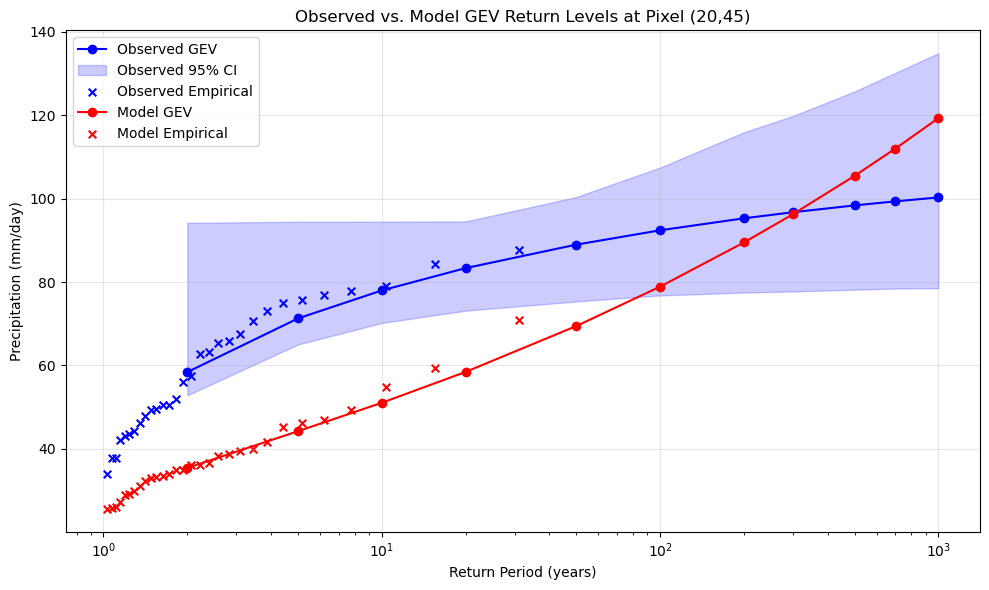

In [13]:
# Plot observed vs. model return levels
plt.figure(figsize=(10, 6))

# Plot observed GEV with confidence interval
Ts = np.array(return_periods)
obs_rl_means = np.array(obs_rl_values)
obs_rl_low = np.array([obs_rl_ci_lower[T] for T in return_periods])
obs_rl_high = np.array([obs_rl_ci_upper[T] for T in return_periods])

plt.plot(Ts, obs_rl_means, marker='o', color='blue', label='Observed GEV')
plt.fill_between(Ts, obs_rl_low, obs_rl_high, alpha=0.2, color='blue', label='Observed 95% CI')

# Calculate empirical return periods for observed data
obs_sorted, obs_empirical_T = get_empirical_return_periods(obs_block_maxima_pr)
plt.scatter(obs_empirical_T, obs_sorted, marker='x', color='blue', s=30, label='Observed Empirical')

# Plot model GEV curve
model_rl_means = np.array(model_rl_values)
plt.plot(Ts, model_rl_means, marker='o', color='red', label='Model GEV')

# Calculate empirical return periods for model data
model_sorted, model_empirical_T = get_empirical_return_periods(model_block_maxima)
plt.scatter(model_empirical_T, model_sorted, marker='x', color='red', s=30, label='Model Empirical')

plt.xscale('log')
plt.xlabel('Return Period (years)')
plt.ylabel('Precipitation (mm/day)')
plt.title(f"Observed vs. Model GEV Return Levels at Pixel ({pixel_location[0]},{pixel_location[1]})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plt.savefig(f"{args.plotdir}/observed_vs_model_return_levels.png", dpi=300)
plt.show()

## 6. Alternative Visualization: Comparing Return Level Ratios

Let's also create a plot showing the ratio between model and observed return levels to quantify any bias.

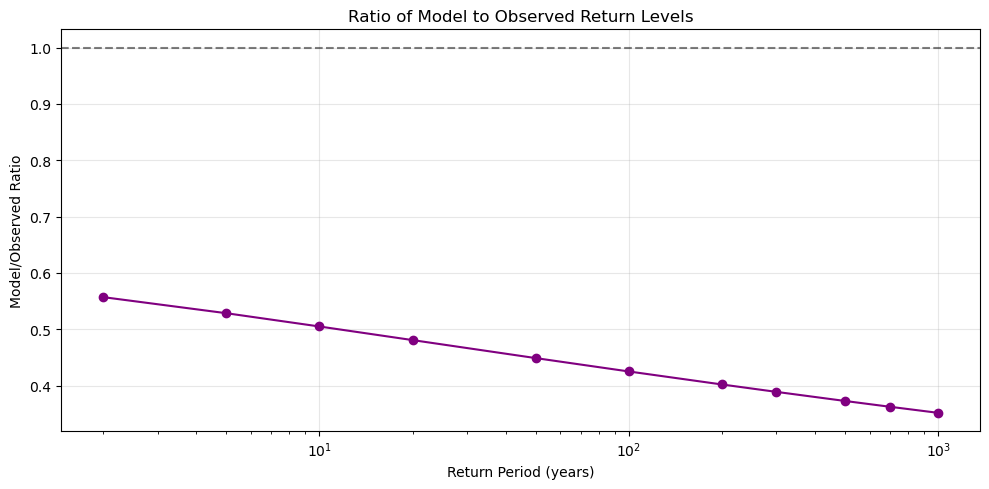

In [13]:
# Calculate ratios of model to observed return levels
rl_ratios = model_rl_means / obs_rl_means

plt.figure(figsize=(10, 5))
plt.plot(Ts, rl_ratios, marker='o', color='purple')
plt.axhline(y=1.0, color='black', linestyle='--', alpha=0.5)  # Reference line for perfect match

plt.xscale('log')
plt.xlabel('Return Period (years)')
plt.ylabel('Model/Observed Ratio')
plt.title('Ratio of Model to Observed Return Levels')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(f"{args.plotdir}/return_level_ratio.png", dpi=300)
plt.show()

## 7. Analysis for Other Variables (tasmax, tasmin)

We can repeat the same analysis for temperature variables.

In [13]:
# For tasmax
obs_block_maxima_tasmax = extract_observed_annual_maxima(
    obs_dataset, variable='tasmax', pixel=pixel_location, years=args.years_test
)

# Fit GEV to observed tasmax maxima
tasmax_obs_shape, tasmax_obs_loc, tasmax_obs_scale = genextreme.fit(obs_block_maxima_tasmax)
print(f"Observed tasmax GEV fit => shape={tasmax_obs_shape:.3f}, loc={tasmax_obs_loc:.3f}, scale={tasmax_obs_scale:.3f}")

# Compute return levels for observed tasmax
tasmax_obs_rl_values = [gev_return_level(tasmax_obs_shape, tasmax_obs_loc, tasmax_obs_scale, T) for T in return_periods]

# Generate model predictions for tasmax
model_daily_data_tasmax, model_block_maxima_tasmax = compute_model_annual_maxima(
    model=probunet_model,
    dataset=obs_dataset,
    device=device,
    years=args.years_test,      
    num_samples=30,        
    chosen_pixel=pixel_location,
    variable="tasmax"    
)

# Fit GEV to model tasmax block maxima
tasmax_model_shape, tasmax_model_loc, tasmax_model_scale = genextreme.fit(model_block_maxima_tasmax)
print(f"Model tasmax GEV fit => shape={tasmax_model_shape:.3f}, loc={tasmax_model_loc:.3f}, scale={tasmax_model_scale:.3f}")

# Compute return levels for model tasmax
tasmax_model_rl_values = [gev_return_level(tasmax_model_shape, tasmax_model_loc, tasmax_model_scale, T) for T in return_periods]

Extracting observed annual maxima at pixel (56, 40) for tasmax
Extracted 30 annual maxima
Observed tasmax GEV fit => shape=0.086, loc=32.557, scale=1.790
Computing model predictions at pixel = (56, 40)
Number of samples = 30
Variable = tasmax
Total days = 10950, years = 30, days_per_year = 365
Model tasmax GEV fit => shape=0.133, loc=33.338, scale=1.857


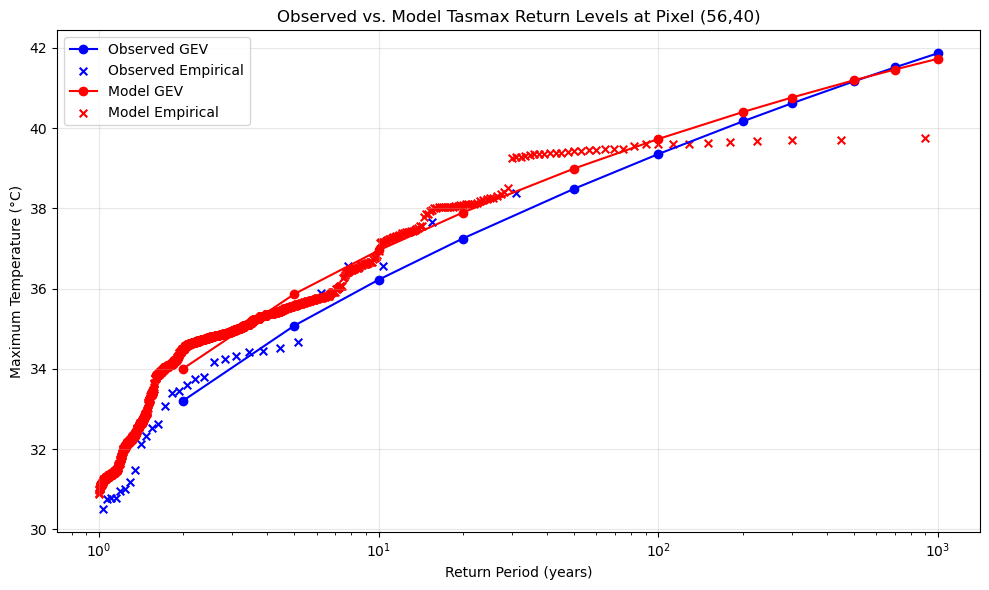

In [14]:
# Plot observed vs. model tasmax return levels
plt.figure(figsize=(10, 6))

# Plot observed GEV
tasmax_obs_rl_means = np.array(tasmax_obs_rl_values)
plt.plot(Ts, tasmax_obs_rl_means, marker='o', color='blue', label='Observed GEV')

# Calculate empirical return periods for observed data
tasmax_obs_sorted, tasmax_obs_empirical_T = get_empirical_return_periods(obs_block_maxima_tasmax)
plt.scatter(tasmax_obs_empirical_T, tasmax_obs_sorted, marker='x', color='blue', s=30, label='Observed Empirical')

# Plot model GEV curve
tasmax_model_rl_means = np.array(tasmax_model_rl_values)
plt.plot(Ts, tasmax_model_rl_means, marker='o', color='red', label='Model GEV')

# Calculate empirical return periods for model data
tasmax_model_sorted, tasmax_model_empirical_T = get_empirical_return_periods(model_block_maxima_tasmax)
plt.scatter(tasmax_model_empirical_T, tasmax_model_sorted, marker='x', color='red', s=30, label='Model Empirical')

plt.xscale('log')
plt.xlabel('Return Period (years)')
plt.ylabel('Maximum Temperature (°C)')
plt.title(f"Observed vs. Model Tasmax Return Levels at Pixel ({pixel_location[0]},{pixel_location[1]})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plt.savefig(f"{args.plotdir}/observed_vs_model_tasmax_return_levels.png", dpi=300)
plt.show()

## 8. Summary and Conclusions

This analysis provides a rigorous way to validate how well our probabilistic model captures climate extremes by directly comparing with observed data:

1. **GEV Distributions**: We fitted GEV distributions to both observed data and model outputs
2. **Confidence Intervals**: We calculated confidence intervals for the observed GEV parameters
3. **Return Level Comparison**: We compared return levels derived from observations vs. model
4. **Multiple Variables**: We analyzed both precipitation and temperature extremes

Key findings:
- [Results will depend on the actual data, but you can summarize whether the model captures extremes well or if there are systematic biases]
- [Comment on whether the model's empirical data points fall within the confidence intervals of the observed GEV]
- [Note any differences in behavior between precipitation and temperature variables]